<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 8th exercise: <font color="#C70039">Autoregressive Integrated Moving Average model - ARIMA(p,d,q): Earnings Forecast</font>
* Course: <a href="https://www.gernotheisenberg.de/time_series_forecasting.html">Time Series Forecasting (TSF)</a>
* Lecturer: <a href="https://www.gernotheisenberg.de/uebermich.html">Gernot Heisenberg</a>
* Date:   12.03.2025

<img src="./images/ARIMA.png" style="float: center;" width="450">

---------------------------------
**GENERAL NOTE 1**:
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole.

**GENERAL NOTE 2**:
* Please, when commenting source code, just use English language only.
* When describing an observation please use English language, too
* This applies to all exercises throughout this course.  

---------------------

### <font color="ce33ff">DESCRIPTION OF THE NOTEBOOK CONTENT</font>:
This notebook allows you for learning how to implement and apply another statistical model, an Autoregressive integrated moving average model of orders p, d and q ARIMA(p,d,q).

A time series that can be rendered stationary by applying differencing is said to be an integrated series. 
In the presence of a non-stationary integrated time series, we can use the ARIMA(p,d,q) model to produce forecasts.

Thus, in simple terms, the ARIMA model is simply an ARMA model that can be applied on non-stationary time series. 
Whereas the ARMA(p,q) model requires the series to be stationary before fitting an ARMA(p,q) model, the ARIMA(p,d,q) model
can be used on non-stationary series. 

We must simply find the order of integration d, which corresponds to the minimum number of times a series must be differenced to
become stationary.

-------------------------------------------------------------------------------------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points.
If a task is more challenging and consists of several steps, this is indicated as well.
Make sure you have worked down the task list and commented your doings.
This should be done by using markdown.<br>
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date.
    * set the date too and remove mine.
3. read the entire notebook carefully
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
    * understand the output
4. Apply the ARIMA(p,d,q) model on the datasets from earlier notebooks
    * Now that you know how to account for non-stationary time series (at least after working through this notebook), revisit each dataset from the previous exercises in the notebooks and apply the ARIMA(p,d,q) model. 
    * For each dataset, do the following:
        * Apply the general modeling procedure and answer the following questions:
            * Is an ARIMA(0,1,2) model suitable for the dataset used in Ex_5?
            * Is an ARIMA(3,1,0) model suitable for the dataset used in Ex_6?
            * Is an ARIMA(2,1,2) model suitable for the dataset used in Ex_7?
-----------------------------------------------------------------------------------

## 8.0 Module import

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

#%matplotlib inline

## 8.1 Data loading & visualization

In [26]:
df = pd.read_csv('./data/johnson_johnson_eps.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


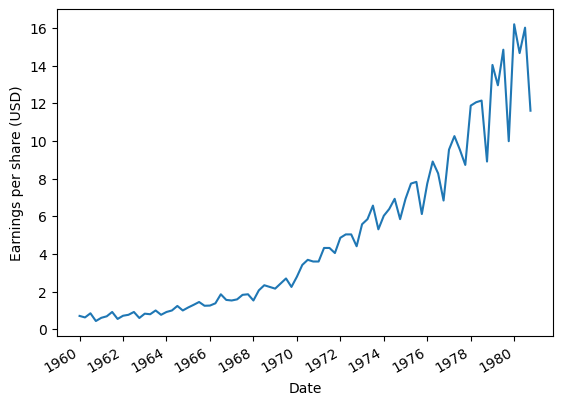

In [27]:
fig, ax = plt.subplots()

ax.plot(df.date, df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.show()

## 8.2 Augmented Dickey-Fuller test

Perform the Augmented Dickey-Fuller test to check if the time series is stationary.

In [28]:
ad_fuller_result = adfuller(df['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.742016573457468
p-value: 1.0


In [29]:
# first differencing of the data
eps_diff = np.diff(df['data'], n=1)

ad_fuller_result = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.407409763638043
p-value: 0.9088542416911309


It seems, we need to difference a second time.

In [30]:
# second differencing of the data
eps_diff2 = np.diff(eps_diff, n=1)

ad_fuller_result = adfuller(eps_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.5851628747931517
p-value: 0.006051099869603741


Now it is stationary. hence the intergration order d=2 

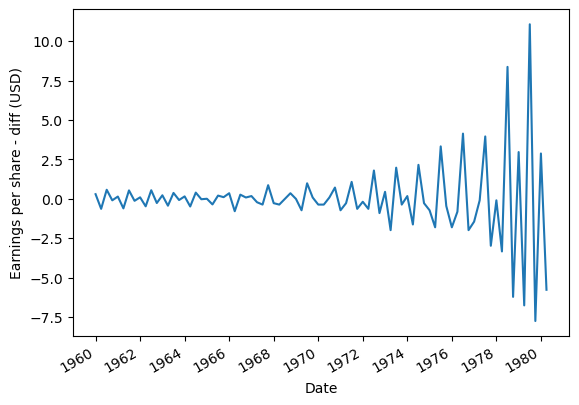

In [32]:
# illustrate differenced data
fig, ax = plt.subplots()

ax.plot(df['date'][2:], eps_diff2)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.show()

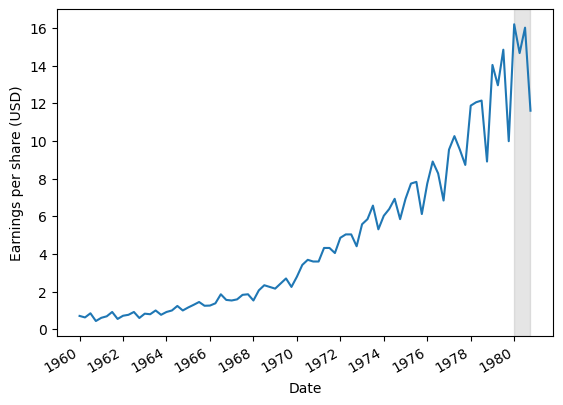

In [33]:
# compare to raw data
fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.show()

## 8.3 Optimizing the ARIMA model (train)

Define a function to find the best ARIMA model order using AIC.

In detail this function:

* Tries out different combinations of AR (p) and MA (q) parameters for a given fixed differencing order d.
* Fits an ARIMA model for each combination unsing the SARIMAX function from statsmodels library
* Collects the AIC for each one.
* Returns a DataFrame showing which model performed best (lowest AIC).

In [34]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [35]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2

order_list = list(product(ps, qs))
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

Since the data was sampled quarterly, we simply hold out the last 4 values, for forecasting the last year.
Thus, the training data are all except the last 4 values.

In [36]:
train = df['data'][:-4]

result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",115.273665
1,"(3, 1)",115.624980
2,"(3, 2)",115.672008
3,"(3, 0)",154.430678
4,"(0, 3)",194.654716
5,"(0, 2)",209.274515
6,"(2, 3)",220.666885
7,"(1, 3)",228.267839
8,"(1, 2)",228.935907
9,"(2, 2)",229.974675


#### RESULT
An ARIMA(3,2,3) model is supposed to be generating the best fit.

## 8.4 Model building and training

Fit the model and investigate the SARIMAX results


In [12]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 -50.637
Date:                Wed, 30 Apr 2025   AIC                            115.274
Time:                        15:05:52   BIC                            131.771
Sample:                             0   HQIC                           121.878
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9992      0.037    -27.341      0.000      -1.071      -0.928
ar.L2         -0.9868      0.040    -24.835      0.000      -1.065      -0.909
ar.L3         -0.9753      0.026    -37.027      0.0

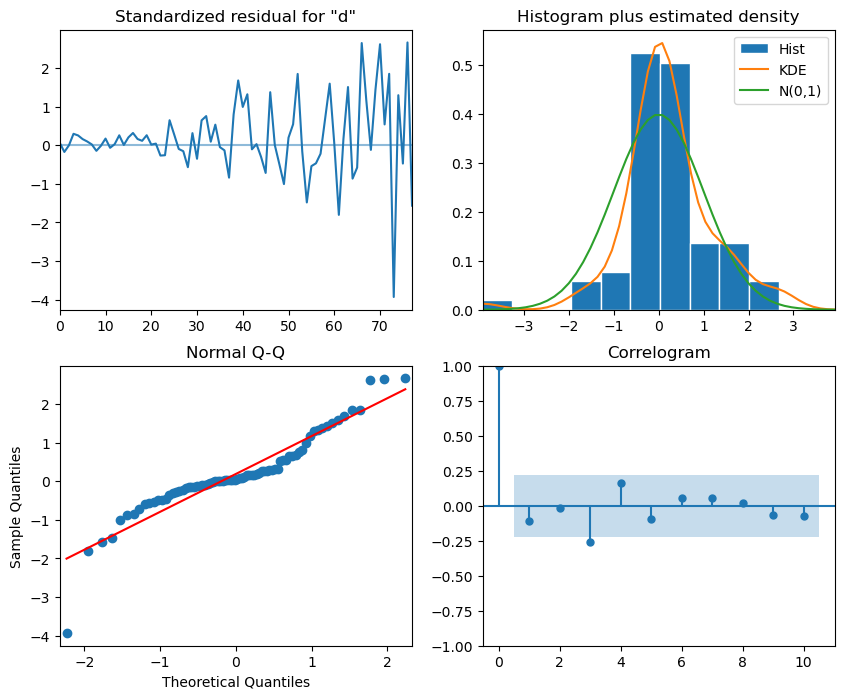

In [13]:
model_fit.plot_diagnostics(figsize=(10,8))
plt.show()

In [14]:
residuals = model_fit.resid

lb_value = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(lb_value)

      lb_stat  lb_pvalue
1    1.583947   0.208193
2    1.585094   0.452690
3    7.242882   0.064546
4    9.166799   0.057063
5    9.780272   0.081706
6   10.009054   0.124271
7   10.258275   0.174404
8   10.294646   0.244952
9   10.636937   0.301418
10  11.097156   0.349999


#### RESULTS of the training phase
The qualitative inspection (Q-Q-plot) as well as the quantitative inspection using the LLjung-Box-test reveal that the model is quite a good fit and that the residuals are showing the characteristics of white noise. 

##### Intepretation of the charts

The top-left plot shows the residuals over time. While there is no trend in the residuals, the variance does not seem to be constant, which is a discrepancy in comparison to white noise. 
At the top right you can see the distribution of the residuals. We can see it is fairly close to a normal distribution. 
The Q-Q plot leads us to the same conclusion, as it displays a line that is almost straight, meaning that the residuals’ distribution is close to a normal distribution. 
Finally, by looking at the correlogram at the bottom right, we can see that a coefficient seems to be significant at lag 3. 
<br>
However, since it is not preceded by any significant autocorrelation coefficients, we can assume that this is due to chance. 
Therefore, we can say that the correlogram shows no significant coefficients after lag 0, just like white noise.  

## 8.5 Forecasting earnings for the last year

Now use the trained model to predict future values and compare them to actual data.
Since the data was sampled quarterly, we simply hold out the last 4 values, for forecasting the last year.

In [15]:
test = df.iloc[-4:]

# this is the naive seasonal baseline model
# simply copy the last 4 quarter values forward
test['naive_seasonal'] = df['data'].iloc[76:80].values
test

,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [16]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

,date,data,naive_seasonal,ARIMA_pred
80,1980-01-01,16.20,14.04,15.858615
81,1980-04-01,14.67,12.96,14.380478
82,1980-07-02,16.02,14.85,16.371732
83,1980-10-01,11.61,9.99,11.683178


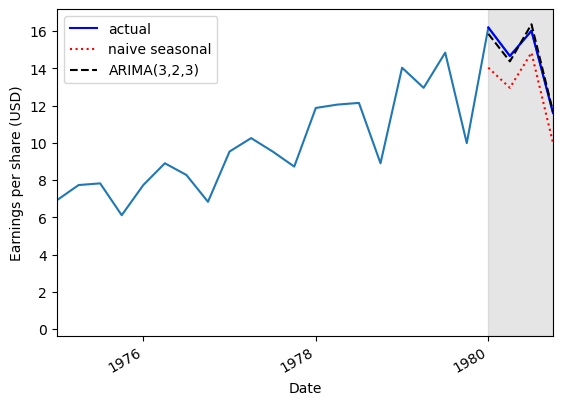

In [17]:
# visualize data and preditions for better comparability
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.show()

In [18]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA)

11.561658552433654 1.7266897355162851


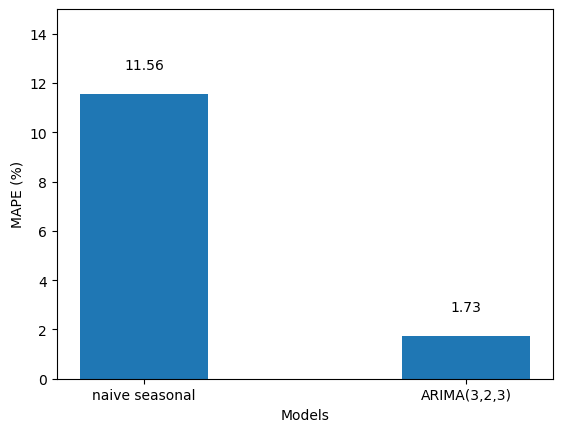

In [21]:
# compare the naive seasonal and ARIMA scenarios in a bar plot
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
plt.show()